In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('full_data_clustered_ssim_V4.csv')
data = data.replace(np.nan,'None')
data = data.drop(columns=['cluster','cluster_2'])
print(data.shape)

df = data.copy()
df = df[df['Authentication']!='Single system']
df = df[df['Access']!='Unknown']
df = df.reset_index().drop(columns=['level_0'])
print(df.shape)

#after features selection
cols = ['Access','Complexity','Authentication','Conf.','Integ.','Avail']
numerical_cols = ['Score','Number Of Related Vulnerabilities']

from sklearn.preprocessing import MinMaxScaler , StandardScaler
mnScaler = MinMaxScaler()
mn_scaler = mnScaler.fit_transform(df[numerical_cols])

ohe_mn_scaled = pd.concat([
    pd.get_dummies(df[cols],dtype=float),
    pd.DataFrame(mn_scaler,columns=numerical_cols)
],axis=1) 
# bad results when we use scaled data in kmeans

ohe = pd.concat([
    pd.get_dummies(df[cols],dtype=float),
    df[numerical_cols]
], axis=1)


for col in cols:
    print(df[col].nunique(),'\t',df[col].unique())
    
ohe.shape

(61698, 22)
(52634, 22)
3 	 ['Remote' 'Local' 'Local Network']
3 	 ['Medium' 'Low' 'High']
2 	 ['Not required' 'Unknown']
3 	 ['None' 'Partial' 'Complete']
3 	 ['Partial' 'None' 'Complete']
3 	 ['None' 'Partial' 'Complete']


(52634, 19)

In [3]:


def clustering_data(x, model):
    
    model.fit_predict(x)
    print(np.unique(model.labels_))    
    cluster_map = pd.DataFrame()
    cluster_map['index_clustermap'] = range(1,len(x)+1)
    cluster_map[f'{model}'] = model.labels_
    cols = ['index','Vulnerability Type(s)','Vulnerability Name','Access','Complexity','Authentication','Conf.','Integ.','Avail'
       ,'Score','Number Of Related Vulnerabilities']
    clustered_data = pd.concat([df[cols] , cluster_map[f'{model}']] , axis=1)
    print(clustered_data[f'{model}'].value_counts())
    
    
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt    
    n_clusters = 2
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(x)
    # Plotting the clusters
    plt.figure(figsize=(8, 6))
    for i in range(n_clusters):
        plt.scatter(reduced_data[clustered_data.iloc[:,-1] == i, 0], 
                    reduced_data[clustered_data.iloc[:,-1] == i, 1], label=f'Cluster {i+1}')
    plt.title(f'{clustered_data.columns[-1]} Clustering')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

    
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    n_clusters = 2
    pca = PCA(n_components=3)
    reduced_data = pca.fit_transform(x)
    # Plotting the clusters in 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(n_clusters):
        ax.scatter(reduced_data[clustered_data.iloc[:,-1] == i, 0], 
                   reduced_data[clustered_data.iloc[:,-1] == i, 1], 
                   reduced_data[clustered_data.iloc[:,-1] == i, 2], label=f'Cluster {i}')
    ax.set_title(f'{clustered_data.columns[-1]} Clustering (3D)')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend()
    plt.show()
    
    
    import plotly.graph_objects as go
    from sklearn.decomposition import PCA
    n_clusters = 2
    pca = PCA(n_components=3)
    reduced_data = pca.fit_transform(x)
    # Create a trace for each cluster
    dataa = []
    for i in range(n_clusters):
        trace = go.Scatter3d(
            x=reduced_data[clustered_data.iloc[:,-1] == i, 0],
            y=reduced_data[clustered_data.iloc[:,-1] == i, 1],
            z=reduced_data[clustered_data.iloc[:,-1] == i, 2],
            mode='markers',
            name=f'Cluster {i}',
            marker=dict(size=5)
        )
        dataa.append(trace)
    # Create the layout for the plot
    layout = go.Layout(
        title=f'{clustered_data.columns[-1]} Clustering (3D)',
        scene=dict(
            xaxis_title='Principal Component 1',
            yaxis_title='Principal Component 2',
            zaxis_title='Principal Component 3',
        )
    )
    # Create the figure and plot it
    fig = go.Figure(data=dataa, layout=layout)
    fig.show()
    
    
    from sklearn.metrics import silhouette_score
    from sklearn.metrics import davies_bouldin_score
    from sklearn.metrics import calinski_harabasz_score

    # Calculate the silhouette score (ranges from -1 to 1, higher is better)
    silhouette_avg = silhouette_score(x, clustered_data.iloc[:,-1])
    print("Silhouette Score:", silhouette_avg)

    # Calculate the Davies-Bouldin index (lower is better)
    davies_bouldin_avg = davies_bouldin_score(x, clustered_data.iloc[:,-1])
    print("Davies-Bouldin Index:", davies_bouldin_avg)

    # Calculate the Calinski ()
    calinski_harabasz_score_avg = calinski_harabasz_score(x, clustered_data.iloc[:,-1])
    print("Calinski Score:", calinski_harabasz_score_avg)

    # Get the sum of squared distances of samples to their closest cluster center (inertia)
#     inertia = model.inertia_
#     print("Inertia:", inertia)
    
    df1 = pd.concat([clustered_data,df['CI SCORE']],axis=1)
    # distribution for each cluster
    cluster_0 = df1[df1[f'{model}']==0]
    cluster_0_scores = cluster_0['CI SCORE']
    cluster_1 = df1[df1[f'{model}']==1]
    cluster_1_scores = cluster_1['CI SCORE']

    plt.figure(figsize=(10,5))
    sn.histplot(cluster_0_scores,label='Cluster 0')
    sn.histplot(cluster_1_scores,label='Cluster 1')

    plt.title('Histogram of CI SCORE by Cluster')
    plt.xlabel('CI SCORE')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


    return clustered_data
    
    

[0 1]
Birch(n_clusters=2)
1    30322
0    22312
Name: count, dtype: int64


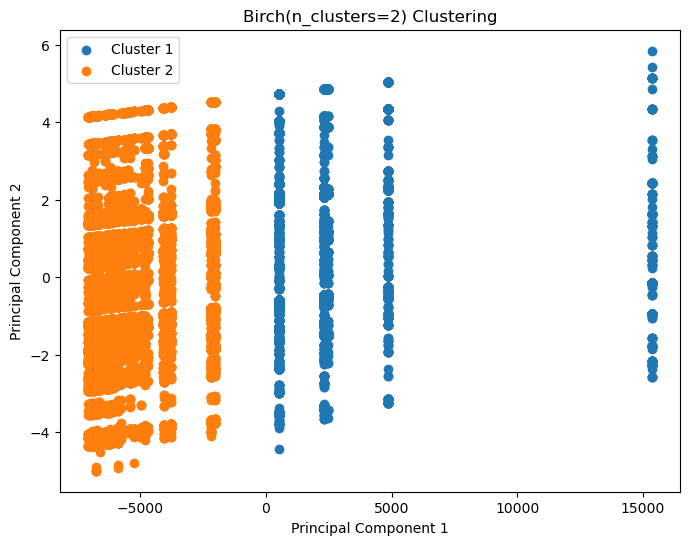

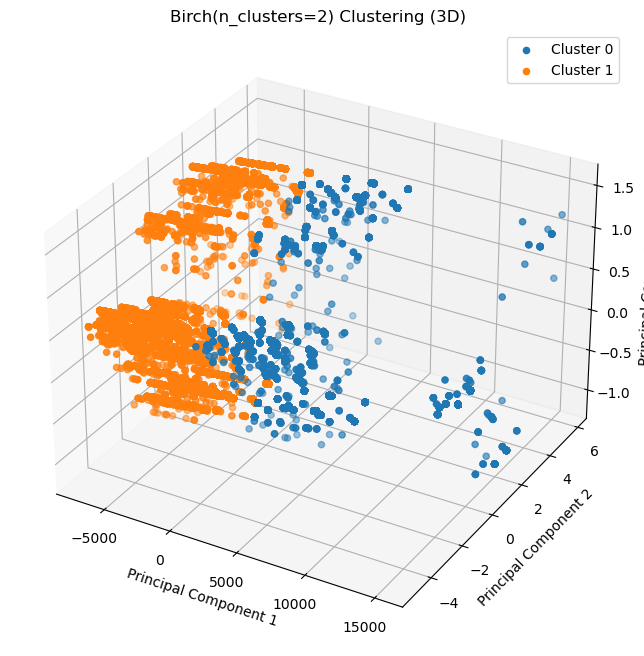

Silhouette Score: 0.6104393360078345
Davies-Bouldin Index: 0.632406982555453
Calinski Score: 94827.7603107571


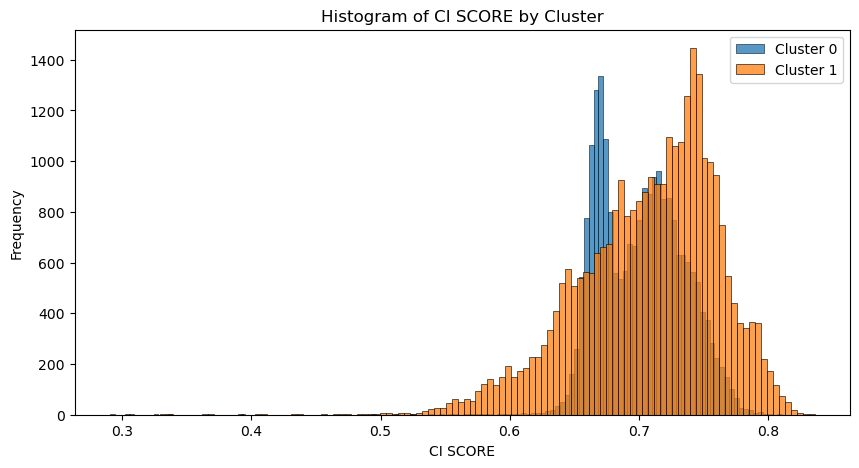

,index,Vulnerability Type(s),Vulnerability Name,Access,Complexity,Authentication,Conf.,Integ.,Avail,Score,Number Of Related Vulnerabilities,Birch(n_clusters=2)
0,1,XSS,Failure to Preserve Web Page Structure ('Cross...,Remote,Medium,Not required,None,Partial,None,4.3,22413.0,0
1,2,Unknown,Improper Authentication,Remote,Low,Not required,Partial,Partial,Partial,7.5,3011.0,1
2,3,Unknown,URL Redirection to Untrusted Site ('Open Redir...,Remote,Medium,Not required,Partial,Partial,None,5.8,754.0,1
3,4,Unknown,Improper Input Validation,Remote,Low,Not required,None,Partial,None,5.0,9380.0,0
4,5,Unknown,Double Free,Local,Low,Not required,Partial,None,None,2.1,394.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
52629,61694,XSS,Failure to Preserve Web Page Structure ('Cross...,Remote,Medium,Not required,None,Partial,None,4.3,22413.0,0
52630,61695,DoS,Uncontrolled Resource Consumption ('Resource E...,Remote,Low,Not required,None,None,Partial,5.0,1320.0,1
52631,61696,Unknown,URL Redirection to Untrusted Site ('Open Redir...,Remote,Medium,Not required,Partial,Partial,None,5.8,754.0,1
52632,61697,XSS,Failure to Preserve Web Page Structure ('Cross...,Remote,Medium,Not required,None,Partial,None,4.3,22413.0,0


In [4]:
from sklearn.cluster import KMeans, BisectingKMeans, MiniBatchKMeans, Birch


df_cluster = clustering_data(
    x = ohe,
    model = Birch(n_clusters = 2)
)
df_cluster
# df_cluster.iloc[:,-1].value_counts()